# Alzheimer prediction using gray matter density from T1w MRI 

**Deadline**: Upload this notebook (rename it as 'TP4-Trees-YOUR-SURNAME.ipynb') with your answers and code to the Moodle/Ecampus before the deadline.


We will use a dataset composed of neuroimaging features from brain T1w MR images of 752 subjects, 416 controls and 336 with Alzheimer’s disease. Following the pipeline described in [1], all images are first normalized to a
common space, providing a voxel-wise correspondence across subjects. Then, gray matter density is computed at each voxel and averaged over a set of ROIs (Region of Interest) of an atlas, at the beginning you will use the [AAL2 atlas](http://www.gin.cnrs.fr/en/tools/aal/). Data comes from several freely available datasets, like [ADNI](http://adni.loni.usc.edu/) and [OASIS](https://www.oasis-brains.org/), and has been pre-processed by the [Clinica](http://www.clinica.run/) team using the procedure explained in [1].

Please load the data from the file: *dataTP.npz* where *T1xxxx* is a matrix containing the averaged density (each row is a subject and each column a feature), *y* is a vector containing the diagnosis (0 for controls and 1 for Alzheimer’s patients) and *ROIlabelsx* contains the name of the ROI of each feature. Here, *x* can take the name of the three atlases you have at your disposal: AAL2, [AICHA](http://www.gin.cnrs.fr/fr/outils/aicha/), [HAMMERS](https://brain-development.org/brain-atlases/adult-brain-atlases/).

**Reference**:
[1] J. Samper-González, N. Burgos, S. Bottani, S. Fontanella, P. Lu, A. Marcoux, A. Routier, J. Guillon, M. Bacci, J. Wen, A. Bertrand, H. Bertin, M.-O. Habert, S. Durrleman, T. Evgeniou, O. Colliot. *Reproducible evaluation of classification methods in Alzheimer's disease: framework and application to MRI and PET data*. NeuroImage, 2018 

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import warnings
warnings.filterwarnings('ignore', category=ImportWarning)

# Libraries
import numpy as np
import matplotlib.pyplot as plt
!pip install -q nilearn
from nilearn import plotting
%matplotlib inline
np.random.seed(seed=666)

from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: C:\Users\lmcastanedame\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='11cQmPm64k3T7ml5fPLetZgb1j1AjHBH8',
dest_path='./dataTP.npz')
gdd.download_file_from_google_drive(file_id='1S7e5IrPygE4VV0JTwqJIlyO2S_NhsiI4',
dest_path='./AtlasAAL2.nii')
gdd.download_file_from_google_drive(file_id='1E0pu5jIMpgcs2DQ8lBGWliwEBZvKrnV9',
dest_path='./AtlasAICHA.nii')
gdd.download_file_from_google_drive(file_id='1yltKwULrkHYh79RAh_zAg08r8pQMjRlQ',
dest_path='./AtlasHAMMERS.nii')

with np.load('./dataTP.npz',allow_pickle=True) as data:
    T1AAL2 = data['T1AAL2'] # data from AAL2 Atlas
    T1AICHA = data['T1AICHA'] # data from AICHA Atlas
    T1HAMMERS = data['T1HAMMERS'] # data from HAMMERS Atlas  
    y = data['y'] # classes, 0 for controls and 1 for patients    
    ROIlabelsAAL2 = data['ROIlabelsAAL2'] # labels for ROIs of atlas AAL2 
    ROIlabelsAICHA = data['ROIlabelsAICHA']    # labels for ROIs of atlas AICHA 
    ROIlabelsHAMMERS = data['ROIlabelsHAMMERS']    # labels for ROIs of atlas HAMMERS 

In [3]:
# Choose Atlas (here AAL2)
X = T1AAL2 # T1AAL2, T1AICHA, T1HAMMERS
labels = ROIlabelsAAL2 # ROIlabelsAAL2, ROIlabelsAICHA, ROIlabelsHAMMERS
atlas = './AtlasAAL2.nii' #AtlasAAL2.nii, AtlasAICHA.nii, AtlasHAMMERS.nii

N, M = X.shape # number subjects and ROIs
class_names = ["control","alzheimer"] # y=0, y=1

print('Number of controls and Alzheimer patients is respectively: {0} and {1}'.format(N-np.sum(y), np.sum(y)))
print('Number of ROI (features) is: {0}'.format(M))

Number of controls and Alzheimer patients is respectively: 416.0 and 336.0
Number of ROI (features) is: 120


Using the library nilearn we can also plot the atlas used to define the ROIs:

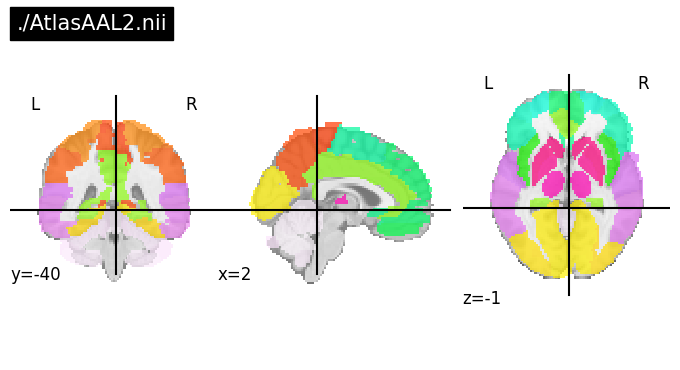

In [4]:
plotting.plot_roi(atlas, title=atlas)
plotting.show()

In this TP we will use Decision Trees, Bagging and Random Forests. Let's start with Decision Trees. First of all, we need to create a training and test set.

In [5]:
# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

And then we need to check whether out features need to be standardized or normalized. Let's have a look at them. Remember that if features can have both negative and positive values, as a rule of thumb, they should be standardized. If they only have positive values, a normalization is usually used. 

As already said, please remember that you should learn the standardization/normalization (namely learn the average/std or the max/min values) ONLY in the training set and then use the same values also in the test set. You should NOT use the entire dataset (both training and test) for standardization/normalization. Otherwise, you would have a *data leakage*, namely you would use data (the test set) that you should not use during training. 

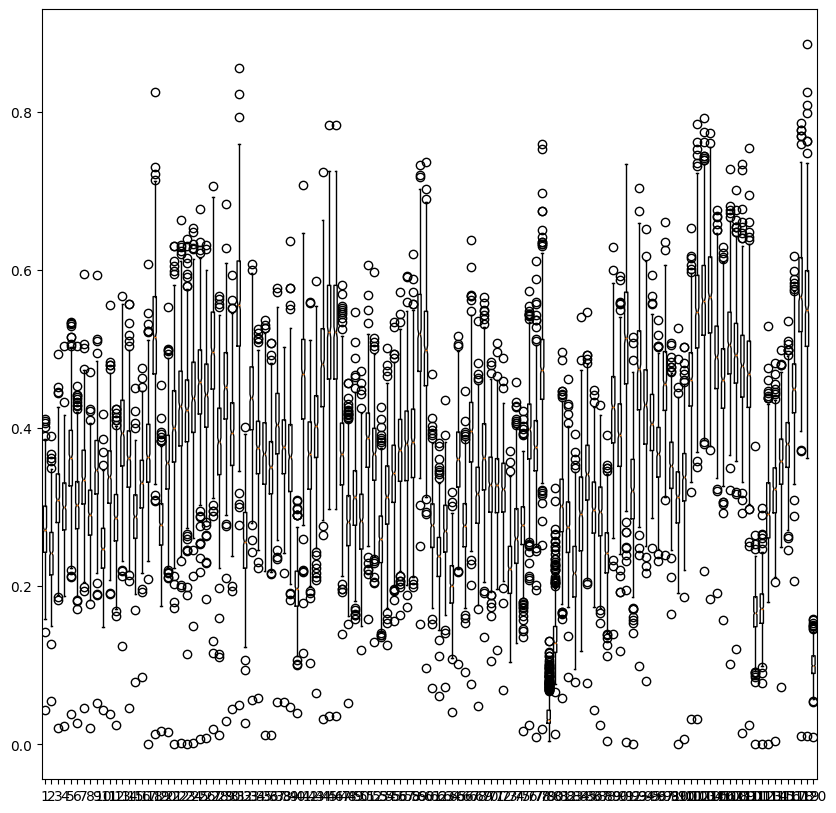

In [6]:
plt.figure(figsize = (10,10))
plt.boxplot(X, notch = True);

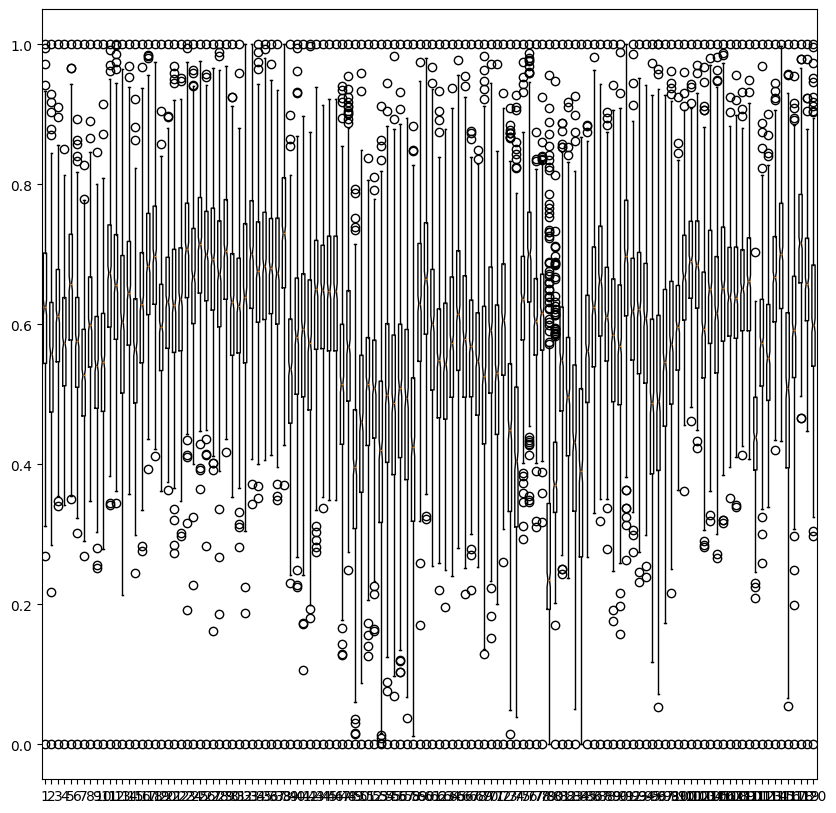

In [7]:
# Normalization of the data (just normalization since the data only contains positive values)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

plt.figure(figsize = (10,10))
plt.boxplot(X_train, notch = True);

Then, we can fit a Decision tree, with the default setting, using the following code:

In [8]:
# Fitting Decision Trees 
Tree = DecisionTreeClassifier(random_state=0)
Tree.fit(X_train,y_train)

# Score in the training set
print('Score in the training set is {0}'.format(Tree.score(X_train,y_train)) )

# Score in the test set
print('Score in the test set is {0}'.format(Tree.score(X_test,y_test)) )

Score in the training set is 1.0
Score in the test set is 0.7123893805309734


Instead than using the default hyperparameters, we could also look for the best ones. Among the hyperparameters implemented in *scikit-learn* we could use *'min_samples_split'*, the minimum number of samples required to split an internal node, and/or *'min_samples_leaf'*, the minimum number of samples required to be present at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. 

Plot the training and test score for different values of 'min_samples_split' (for instance between 2 and 15) WITHOUT using Cross Validation. Do the same for 'min_samples_leaf'.

**Question:** What is the best value ? What happens if you split differently your data (change `random_state`in the function `train_test_split`) ? 


When adjusting the `random_state` parameter in the `train_test_split` function, the random seed that is used to shuffle and split the dataset into training and testing sets is effectively changed. This can lead to different subsets of the data being used in each set across different runs. As a result, changing the `random_state` can have several implications on the outcomes of experimenting with decision tree hyperparameters like `min_samples_split` and `min_samples_leaf`, especially without using cross-validation. 

The training and test scores for different values of `min_samples_split` and `min_samples_leaf` can vary with different splits of the data. Since the composition of the training and testing sets changes, the model may perform better or worse on unseen data, depending on how representative the training data is of the overall dataset.

With certain splits, the decision tree might either overfit or underfit, depending on the characteristics of the data in the training set. For example, a particular split could lead to a training set that's not diverse enough, making the model less generalizable to new data. Conversely, a more representative training set might result in better generalization and test performance.

The optimal values for `min_samples_split` and `min_samples_leaf` might change with different splits of the data. What appears to be the best hyperparameter setting for one particular train-test split might not hold for another split, leading to inconsistencies in identifying the most effective model configuration.

The decision tree's complexity can be affected. For some splits, a lower `min_samples_leaf` or `min_samples_split` might not lead to overfitting, while for others, it might. This can make it challenging to balance model complexity with the ability to generalize without cross-validation.

To mitigate these issues and get more stable and generalizable insights into how `min_samples_split` and `min_samples_leaf` affect model performance, cross-validation is typically recommended. This approach gives a more robust estimate of how hyperparameter changes will perform on average, rather than being overly dependent on a single split of the data.

The value of min_samples_split that maximizes the training score is :  2
The value of min_samples_split that maximizes the test score is :  2


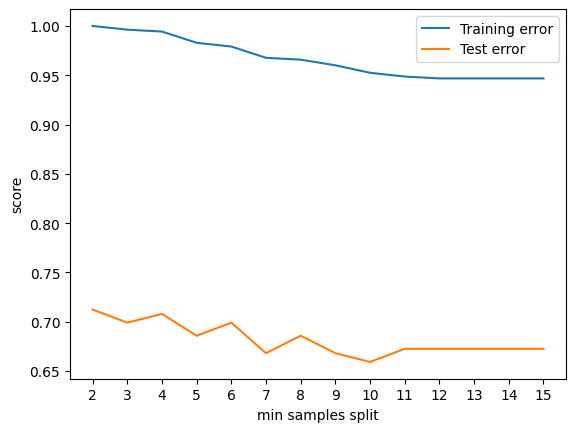

In [9]:
# min_samples_split

TTest = []
TTrain = []
for i in range(2,16):
    Tree = DecisionTreeClassifier(min_samples_split = i, random_state = 0)
    Tree.fit(X_train,y_train)
    scoreTrain = Tree.score(X_train, y_train)
    scoreTest = Tree.score(X_test, y_test)
    TTrain.append(scoreTrain)
    TTest.append(scoreTest)

plt.plot(TTrain, label = 'Training error');
plt.xticks(np.arange(14), ('2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15'))
print("The value of min_samples_split that maximizes the training score is : ", TTrain.index(max(TTrain)) + 2)

plt.plot(TTest, label = 'Test error');
plt.xticks(np.arange(14), ('2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15'))
plt.xlabel('min samples split')
plt.ylabel('score')
print("The value of min_samples_split that maximizes the test score is : ", TTest.index(max(TTest)) + 2)

plt.legend();

The value of min_samples_leaf that maximizes the training score is :  1
The value of min_samples_leaf that maximizes the test score is :  14


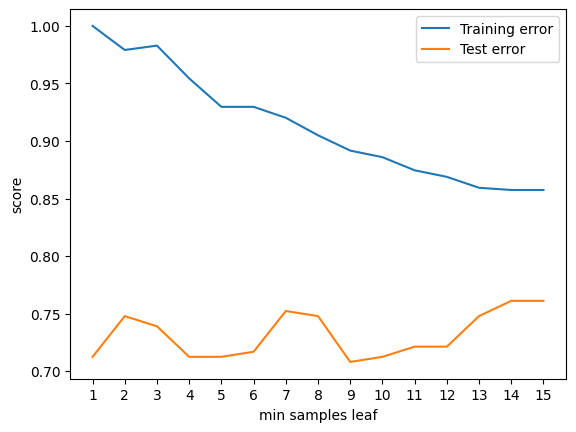

In [10]:
# min_samples_leaf

TTest = []
TTrain = []
for i in range(1,16):
    Tree = DecisionTreeClassifier(min_samples_leaf = i,random_state=0)
    Tree.fit(X_train,y_train)
    scoreTrain = Tree.score(X_train, y_train)
    scoreTest = Tree.score(X_test, y_test)
    TTrain.append(scoreTrain)
    TTest.append(scoreTest)

plt.plot(TTrain, label = 'Training error');
plt.xticks(np.arange(15), ('1', '2', '3', '4', '5','6','7','8','9','10','11','12','13','14','15'))
print("The value of min_samples_leaf that maximizes the training score is : ", TTrain.index(max(TTrain)) + 1)

plt.plot(TTest,label = 'Test error');
plt.xticks(np.arange(15), ('1', '2', '3', '4', '5','6','7','8','9','10','11','12','13','14','15'))
plt.xlabel('min samples leaf')
plt.ylabel('score')
print("The value of min_samples_leaf that maximizes the test score is : ", TTest.index(max(TTest)) + 1)

plt.legend();

Try to add Gaussian noise to the data (using for instance zero mean and 0.05 for $\sigma$) and, using the best hyperparameters found before in the test set (you can use both `min_samples_leaf` and `min_samples_split`), look at the test score. Repeat this process several times and compare the results with the score obtained without adding noise. 

**Question**: Are the results stable ? Hint: you could use for instance *noise = np.random.normal(mu, sigma)* if you have standardized the features and *noise = np.abs(np.random.normal(mu, sigma))* if you have normalized them (we use *np.asb()* to take only positive values and $\sigma$ should be small in order to (almost) preserve the range of the features between 0 and 1)

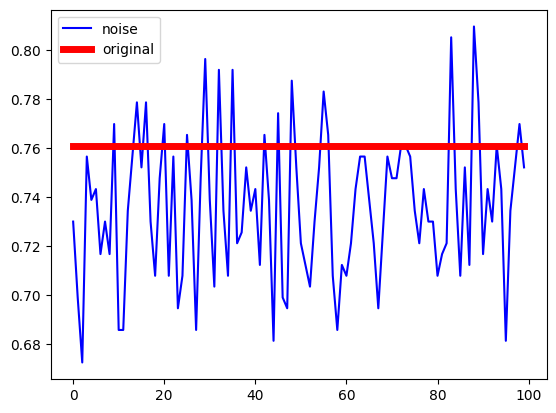

In [11]:
Tree = DecisionTreeClassifier(min_samples_split = 2, min_samples_leaf = 14, random_state = 0)
scoreTestnoise = np.zeros(100)
scoreTest = np.zeros(100)

Tree.fit(X_train, y_train)
scoreTest[:] = Tree.score(X_test, y_test)

for k in range(100):    
    X_train_temp = np.copy(X_train)
    for i in range(X_train.shape[0]):
        X_train_temp[i] = X_train_temp[i] + abs(np.random.normal(0, 0.05, M))
        
    Tree.fit(X_train_temp, y_train)
    scoreTestnoise[k] = Tree.score(X_test, y_test)
    
plt.plot(scoreTestnoise,'b', label = 'noise')
plt.plot(scoreTest, 'r', linewidth = 5.0, label = 'original')       
plt.legend();

The blue line fluctuates, indicating variability in the test scores when noise is added to the training data. This suggests that the model's performance is affected by the perturbations in the input features. The red line is constant, representing the test score of the model with the original data. This serves as a baseline to compare the stability of the test scores from the noisy data.

The blue line's fluctuation around the red line suggests that while the noise does impact the test scores, the general trend appears to maintain around a certain mean value. If the fluctuations were extreme, it would indicate a high level of instability. The range within which the blue line fluctuates gives an indication of the model's sensitivity to noise. A tighter range of fluctuation would suggest that the model is relatively stable despite the noise, whereas a wider range would indicate greater instability.

Given that there is variability but it doesn't seem extreme, we might conclude that the results show some level of stability, but the performance of the model is indeed affected by the noise added to the training data. 

To plot decision trees, we can also use the *graphviz* library. If you need to install it locally, you can do it using *conda install python-graphviz*. 
 

First plot the tree learnt on the original data, witout adding noise.

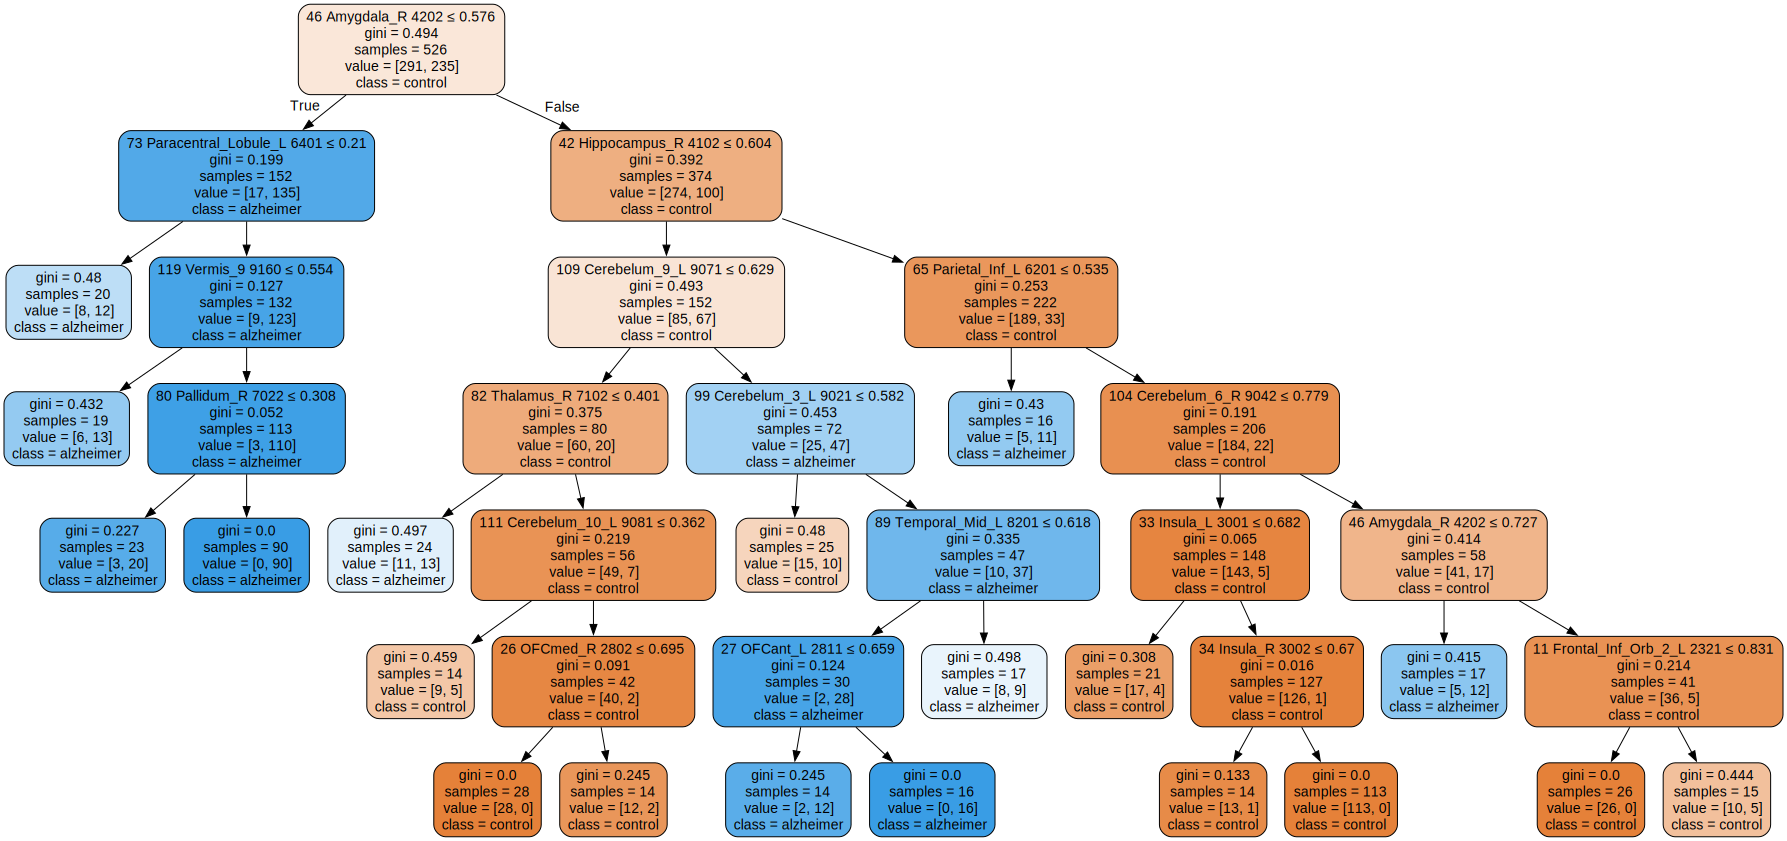

In [12]:
import graphviz 

Tree.fit(X_train, y_train)
dot_data = tree.export_graphviz(Tree, out_file = None, feature_names = labels, class_names = class_names, 
                                filled = True, rounded = True, special_characters = True)
graph = graphviz.Source(dot_data)
graph

Now, plot the tree learnt on noisy data.

**Question**: Is it the same ? You can try several times, for different levels of noise. Comment the results

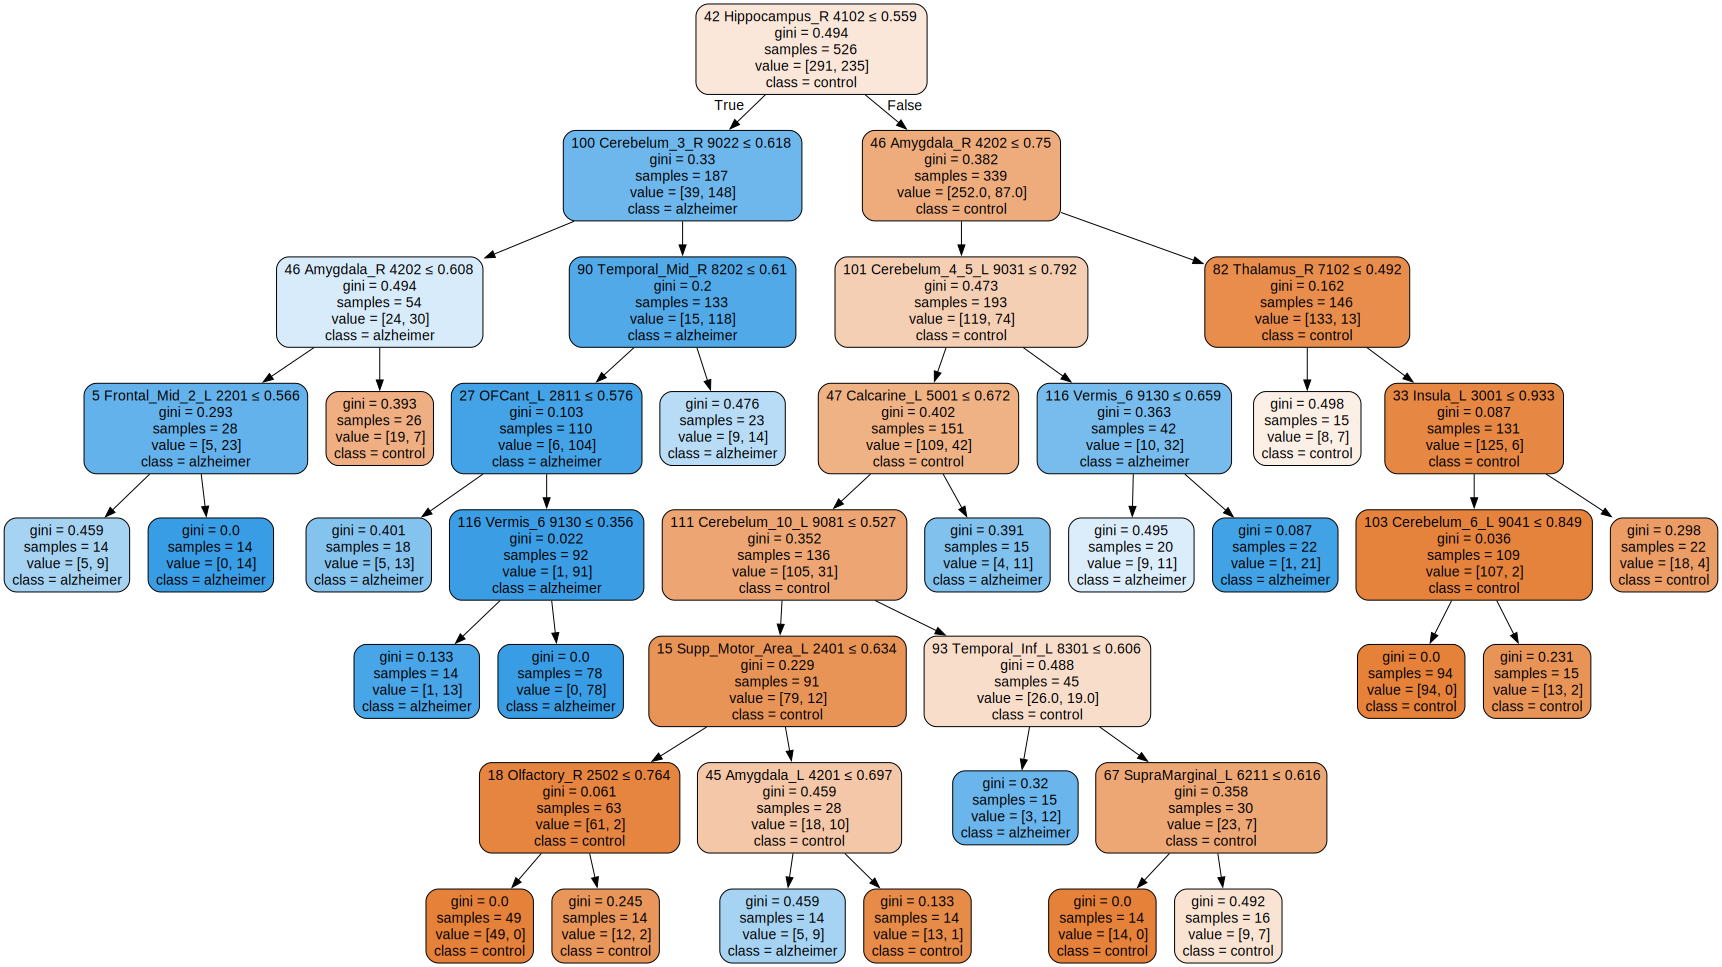

In [13]:
# Plot with Graphviz the tree learned on noisy data
Tree.fit(X_train_temp, y_train)
dot_data = tree.export_graphviz(Tree, out_file = None, feature_names = labels, class_names = class_names, 
                                filled = True, rounded = True, special_characters = True)
graph = graphviz.Source(dot_data)
graph

By examining both trees, it is observed that the tree trained on noisy data shows different feature splits, thresholds, and even different tree depths. This indicates that the noise has influenced the learning process, possibly leading to a model that fits the noise rather than the underlying pattern of the data.

If the tree structure changes significantly after introducing noise, it suggests that the decision tree model is sensitive to variations in the data. Small perturbations lead to different rules and structures, which can imply overfitting where the model captures the noise instead of the signal.

The consistency of the leaf nodes, in terms of the class distribution (values), can be a telltale sign. If noisy data leads to a higher variation in the distribution of classes in leaf nodes across different runs, this indicates that noise has a significant impact on the model's decision-making process.

The decision boundaries established by a tree can be complex and highly non-linear. Noise can cause these boundaries to shift or become more complex, which might not necessarily be visible in the tree structure but can be inferred from changes in the splitting criteria.

A tree that is very deep and has many nodes might have overfitted to the training data, including the noise. This overfitting can manifest as additional branches and nodes that attempt to account for anomalies introduced by noise.

Instead than using a single split of the data, we could also use Cross Validation to compute the best hyperparameter values for both 'min_samples_split' and 'min_samples_leaf' at the same time and in an automatic way. 

**Question:** Do you find the same optimal hyperparameters as before ? Hint: use GridSearchCV

Cross-validation reduces the dependence of the model's performance on a particular train-test split by evaluating the model on multiple subsets of the data. This means that hyperparameters are tested and validated across the entire range of data rather than a single subset, which can lead to different optimal values being selected.

The hyperparameters found by cross-validation are often more robust and generalizable than those found using a single split because they have been validated across multiple data scenarios.

1. **min_samples_split**: It's not uncommon to find the same value for `min_samples_split` because this parameter controls the minimum number of samples required to split an internal node, which can be less sensitive to the data split or noise and more about controlling the growth of the tree to prevent overfitting.

2. **min_samples_leaf**: On the other hand, `min_samples_leaf` determines the minimum number of samples that must be present in a leaf node. This is directly related to the leaf purity and can be more sensitive to specific data distributions. Therefore, it's possible to obtain a different value when using cross-validation because this parameter may significantly affect the model's ability to generalize to new data, which cross-validation will capture more effectively.

Finding different values for `min_samples_leaf` but the same for `min_samples_split` when using GridSearchCV with cross-validation as opposed to a single split, it's an indication that `min_samples_leaf` has a larger impact on the model's ability to generalize beyond the training data. It also suggests that the optimal `min_samples_leaf` value is more sensitive to the variability in the dataset, and the value obtained through cross-validation is likely to be more reliable when applying the model to unseen data.

**Question**: So far, we have used the standard score (ie accuracy). Would you use a different one ? If yes, which one and why ?

The implications of false positives and false negatives are significant, but in different ways:

1. **Recall (Sensitivity)**: This metric measures the proportion of actual positive cases (Alzheimer's patients) correctly identified. High recall is crucial because missing a diagnosis of Alzheimer's could delay treatment and support for the patient.

2. **Precision**: This is the proportion of positive identifications that were actually correct. While a false positive (identifying a control subject as having Alzheimer's) is not as critical as a false negative, it can still cause unnecessary distress and lead to further invasive testing. Therefore, precision should also be considered.

3. **F1 Score**: This is the harmonic mean of precision and recall, providing a single metric that balances the two. 

4. **ROC-AUC**: The area under the receiver operating characteristic curve is useful for understanding a model's discriminative ability at various threshold settings. For medical diagnosis, a high AUC is desirable, indicating that the model can distinguish between control subjects and Alzheimer's patients effectively.

In this context, it might be wanted to be prioritize recall to ensure that Alzheimer's patients are identified accurately for early intervention. However, because a misdiagnosis can also have profound implications, precision remains important to prevent mislabeling healthy control subjects as patients. The use of ROC-AUC and PRC is also appropriate here, as they can handle imbalances in the dataset and provide insight into the performance trade-offs at different thresholds.

In [14]:
Tree = DecisionTreeClassifier(min_samples_split = 2, min_samples_leaf = 14, random_state = 0)
p_grid_tree = {'min_samples_split': range(2,16), 'min_samples_leaf': range(1,16)}
grid_tree = GridSearchCV(estimator=Tree, param_grid = p_grid_tree, cv=5)
grid_tree.fit(X_train, y_train)
print("Best Validation Score: {}".format(grid_tree.best_score_))
print("Best params: {}".format(grid_tree.best_params_))
print("Tree test score :",grid_tree.score(X_test, y_test))

best_params = grid_tree.best_params_

Best Validation Score: 0.7605390835579514
Best params: {'min_samples_leaf': 9, 'min_samples_split': 2}
Tree test score : 0.7079646017699115


Using the estimated optimal hyperparameers, plot the new decision tree using the *graphviz* library. 

**Question**: Is it the same as before? Do you see ROIs that are always close to the root of the tree among the different experiments ? If yes, what does it mean in your opinion ? Comment the results.

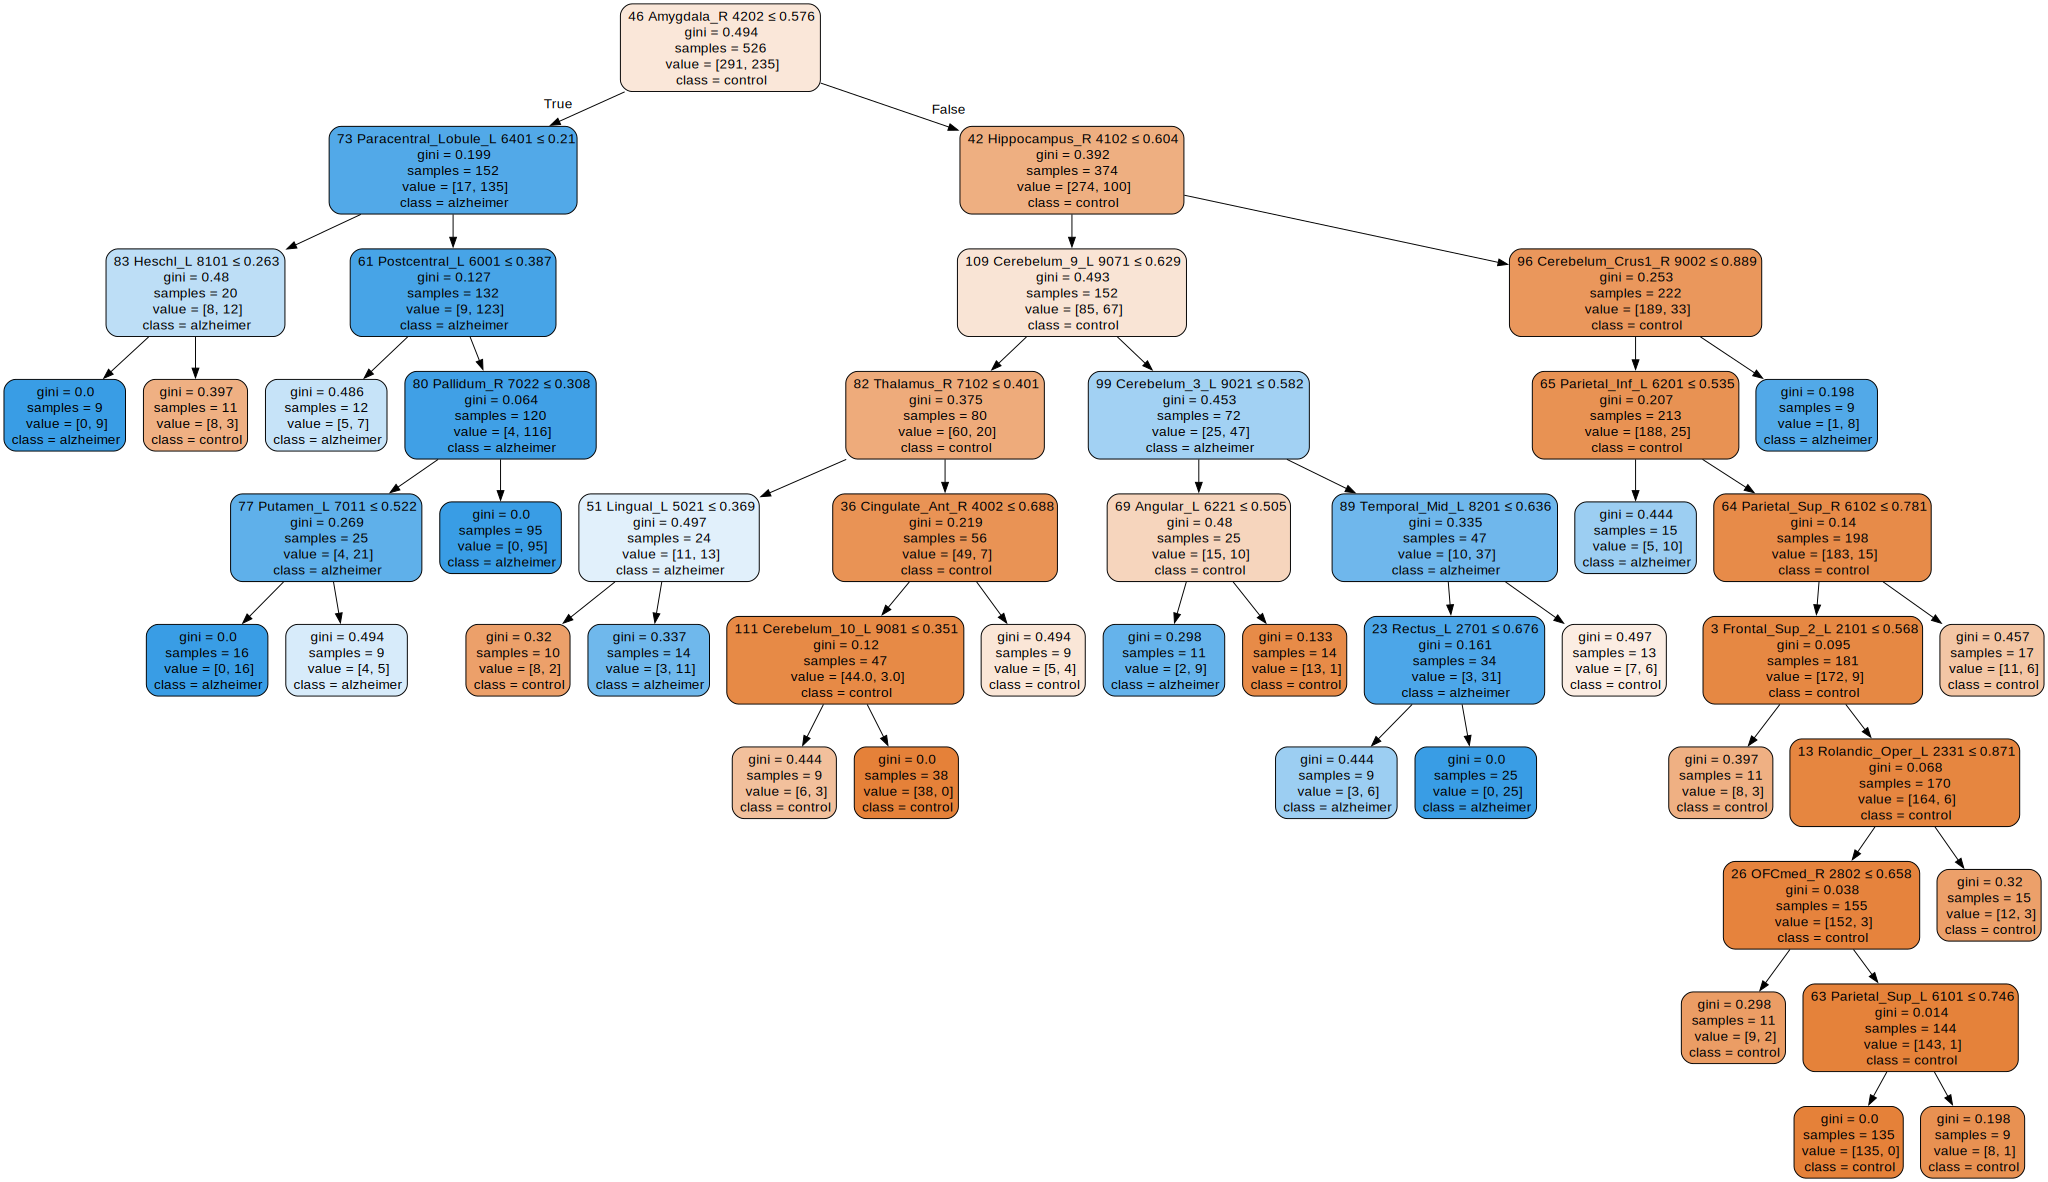

In [15]:
# Plot the new decision tree with Graphviz
Tree = DecisionTreeClassifier(min_samples_split = best_params['min_samples_split'], 
                              min_samples_leaf = best_params['min_samples_leaf'], random_state = 0)
Tree.fit(X_train, y_train)
dot_data = tree.export_graphviz(Tree, out_file = None, feature_names = labels, class_names = class_names, 
                                filled = True, rounded = True, special_characters = True)
graph = graphviz.Source(dot_data)
graph

When comparing the new decision tree to the ones obtained from previous experiments (such as the one trained on the original data without noise and the one trained on noisy data), it is possible that the tree structure may change to some extent due to the altered hyperparameters. The optimal hyperparameters chosen through cross-validation are expected to make the tree generalize better, which can result in differences in the tree depth, number of nodes, and the specific splits used.

If there are Regions of Interest (ROIs) or features that consistently appear close to the root of the tree across different experiments (**Amygdala_R** and **Hippocampus_R**), it suggests that these features are highly discriminative; that is, they provide strong predictive power for the target variable. In the context of decision trees, the root and nodes near it are the most important splits and have the highest information gain. The consistency of these features near the tree root across various experiments indicates their robustness and importance in predicting the outcome, regardless of the particular nuances of the model's training conditions.

This can be particularly insightful in fields like medical diagnosis, where certain biomarkers or symptoms might consistently be the most significant indicators of a disease. The ROIs near the root of the tree could be considered as primary factors for further medical tests or focus areas for treatment.

Try to use now Bagging. You can use the following code where we use the previously computed best parameters 'min_samples_leaf' and 'min_samples_split'. 

**Question**: What happens when you use the original data and the noisy version ? Do you notice any difference in the prediction scores with respect to the results using Decision Trees ? 

In [16]:
Tree = DecisionTreeClassifier(min_samples_leaf = best_params['min_samples_leaf'],
                              min_samples_split = best_params['min_samples_split'], random_state = 0)

p_grid_bagging = {'n_estimators': [5, 10, 15, 20]}      
bag = BaggingClassifier(estimator = Tree, random_state = 0)
grid_bagging = GridSearchCV(estimator = bag, param_grid = p_grid_bagging, cv = 5)
grid_bagging.fit(X_train, y_train)
print("Best Validation Score: {}".format(grid_bagging.best_score_))
print("Best params: {}".format(grid_bagging.best_params_))
print("Bagging test score :",grid_bagging.score(X_test, y_test))

C:\Users\lmcastanedame\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_bagging.py:782: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\lmcastanedame\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_bagging.py:782: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\lmcastanedame\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_bagging.py:782: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

Best Validation Score: 0.8136567834681042
Best params: {'n_estimators': 5}
Bagging test score : 0.7699115044247787


C:\Users\lmcastanedame\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_bagging.py:782: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [17]:
# Bagging on noisy data
Tree = DecisionTreeClassifier(min_samples_leaf = best_params['min_samples_leaf'], 
                              min_samples_split = best_params['min_samples_split'], random_state = 0)

p_grid_bagging = {'n_estimators': [5, 10, 15, 20]}      
bag = BaggingClassifier(estimator = Tree, random_state = 0)
grid_bagging = GridSearchCV(estimator = bag, param_grid = p_grid_bagging, cv = 5)
grid_bagging.fit(X_train_temp, y_train)
print("Best Validation Score: {}".format(grid_bagging.best_score_))
print("Best params: {}".format(grid_bagging.best_params_))
print("Bagging test score :",grid_bagging.score(X_test, y_test))

C:\Users\lmcastanedame\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_bagging.py:782: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\lmcastanedame\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_bagging.py:782: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\lmcastanedame\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_bagging.py:782: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

Best Validation Score: 0.7832165318957772
Best params: {'n_estimators': 20}
Bagging test score : 0.8141592920353983


When applying bagging (Bootstrap Aggregating), an ensemble technique designed to improve the stability and accuracy of machine learning algorithms is being used. It reduces variance and helps to avoid overfitting. Essentially, bagging involves training the same algorithm multiple times using different subsets of the training data, then averaging the predictions.

Decision Trees are prone to overfitting, especially when there is noise in the data. This overfitting will typically lead to a decrease in the test score because the tree models the noise as if it were a real pattern. Bagging mitigates this by averaging out the decisions of multiple trees, each trained on different subsets of the data. This makes the ensemble less sensitive to the noise and can often lead to better generalization (a higher test score) than a single decision tree, especially when the noise is present.

The fact that the bagging classifier has a higher test score on noisy data compared to original data might seem counterintuitive initially. However, this can happen because the noise increases the variability among the trees in the bagging ensemble. If the noise doesn't completely obscure the underlying patterns, this increased variability can actually lead to a more robust ensemble by preventing any single tree from dictating the outcome. The increase in the number of estimators for the noisy data suggests that more trees were needed to capture the underlying patterns amidst the noise. Since bagging can handle a certain level of noise, this increased "wisdom of the crowd" effect helps in achieving a better score on the test set. The lower test score on the original data suggests that with fewer estimators, the ensemble might be underfitting or not capturing all the patterns that could be generalized from the data. Alternatively, the test set might have characteristics or patterns not well-represented in the training set, which affects the ensemble's performance.

The last part of this TP is about Random Forests. We can estimate the three hyperparameters *'n_estimators'*, *'min_samples_leaf'* and *'max_features'*, the number of features to consider when looking for the best split, as before using Cross Validation

In [18]:
RF = RandomForestClassifier(random_state = 0)
p_grid_RF = {'n_estimators': [10, 15, 20, 25, 30], 'min_samples_leaf': [2, 3, 4, 5, 6], 'max_features': ['sqrt', 'log2']}   

grid_RF = GridSearchCV(estimator = RF, param_grid = p_grid_RF, scoring = 'accuracy', cv = 5)
grid_RF.fit(X_train, y_train)

print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("Random Forest test score :", grid_RF.score(X_test, y_test))

C:\Users\lmcastanedame\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\lmcastanedame\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\lmcastanedame\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pleas

Best Validation Score: 0.8270440251572329
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 25}
Random Forest test score : 0.7876106194690266


Using the estimated best hyperparameters, test the performance of Random Forest on the noisy data and compare the results with Decision Trees and Bagging. 

C:\Users\lmcastanedame\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\lmcastanedame\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\lmcastanedame\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pleas

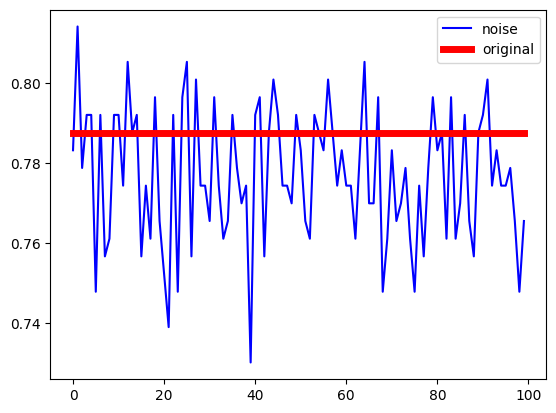

In [19]:
# Random Forest on noisy data
RF = RandomForestClassifier(max_features = grid_RF.best_params_['max_features'],
                            min_samples_leaf = grid_RF.best_params_['min_samples_leaf'],
                            n_estimators = grid_RF.best_params_['n_estimators'], random_state = 0)
RF.fit(X_train, y_train)
scoreTestnoise = np.zeros(100)
scoreTest = np.zeros(100)

scoreTest[:] = RF.score(X_test, y_test)

for k in range(100):
    X_train_temp = np.copy(X_train)
    for i in range(X_train.shape[0]):
        X_train_temp[i] = X_train_temp[i] + abs(np.random.normal(0, 0.05, M))
        
    RF.fit(X_train_temp, y_train)
    scoreTestnoise[k] = RF.score(X_test, y_test)

plt.plot(scoreTestnoise,'b', label = 'noise')
plt.plot(scoreTest, 'r', linewidth = 5.0, label = 'original')
plt.legend();

We can also use Random Forests to check the importance of the features

C:\Users\lmcastanedame\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Feature ranking:
1. feature 45 representing 46 Amygdala_R 4202
 (0.089800)
2. feature 43 representing 44 ParaHippocampal_R 4112
 (0.060235)
3. feature 41 representing 42 Hippocampus_R 4102
 (0.049044)
4. feature 93 representing 94 Temporal_Inf_R 8302
 (0.047599)
5. feature 40 representing 41 Hippocampus_L 4101
 (0.037465)
6. feature 92 representing 93 Temporal_Inf_L 8301
 (0.037159)
7. feature 44 representing 45 Amygdala_L 4201
 (0.034706)
8. feature 59 representing 60 Fusiform_R 5402
 (0.029645)
9. feature 88 representing 89 Temporal_Mid_L 8201
 (0.023978)
10. feature 86 representing 87 Temporal_Pole_Sup_L 8121
 (0.023713)


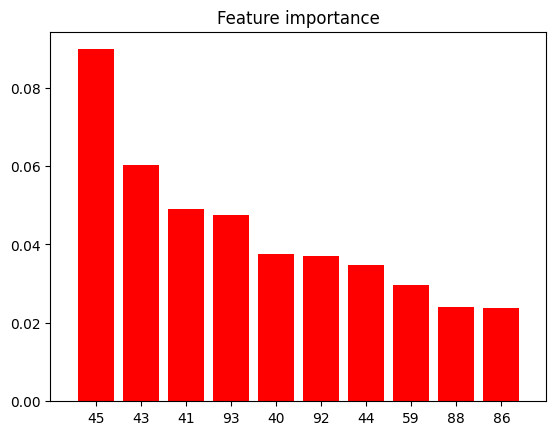

In [20]:
best_params = grid_RF.best_params_
RF = RandomForestClassifier(min_samples_leaf = best_params["min_samples_leaf"], max_features = best_params["max_features"],
                            n_estimators = best_params["n_estimators"], random_state = 0)
RF.fit(X_train,y_train)

importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d representing %s (%f)" % (f + 1, indices[f], labels[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance")
plt.bar(range(10), importances[indices[0:10]], color="r", align="center")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()

**Question**: Which are the most important features (i.e. ROIs) ?  Based on the two given research papers, you can verify if your results make sense. 

The most important features (or Regions of Interest - ROIs) according to the feature importance chart and ranking are:

1. **Feature 45 (Amygdala_R 4202)**: This feature has the highest importance score, indicating that the right Amygdala's activity or structure is highly indicative in differentiating between control subjects and Alzheimer's patients in the study.

2. **Feature 43 (ParaHippocampal_R 4112)**: The right Parahippocampal region is the second most important feature, also playing a significant role in the classification.

3. **Feature 41 (Hippocampus_R 4102)**: The right Hippocampus comes in as the third most important, which is not surprising given its known association with memory and Alzheimer's disease.

4. **Feature 93 (Temporal_Inf_R 8302)**: The right Inferior Temporal cortex is the fourth, suggesting its relevance in the disease process or in its detection.

5. **Feature 40 (Hippocampus_L 4101)**: The left Hippocampus also appears to be important, although slightly less so than the right, reflecting the importance of hippocampal structures in Alzheimer's.

The Amygdala and Hippocampal regions are well-known to be involved in the processes affected by Alzheimer's disease, such as emotional regulation and memory. Their appearance at the top of the feature importance ranking reinforces their relevance in the diagnosis and study of Alzheimer's.

The presence of the Temporal regions (both Inferior and Middle) among the top features is also consistent with the understanding of Alzheimer's disease, which often impacts temporal lobe structures, affecting language, memory, and executive functions.

We can also inspect the data using only pairs of the most important features

C:\Users\lmcastanedame\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\lmcastanedame\AppData\Local\Temp\ipykernel_14576\3244815994.py:30: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(Xpair[idx, 0], Xpair[idx, 1], c=color, label=class_names[i],
C:\Users\lmcastanedame\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\lmcast

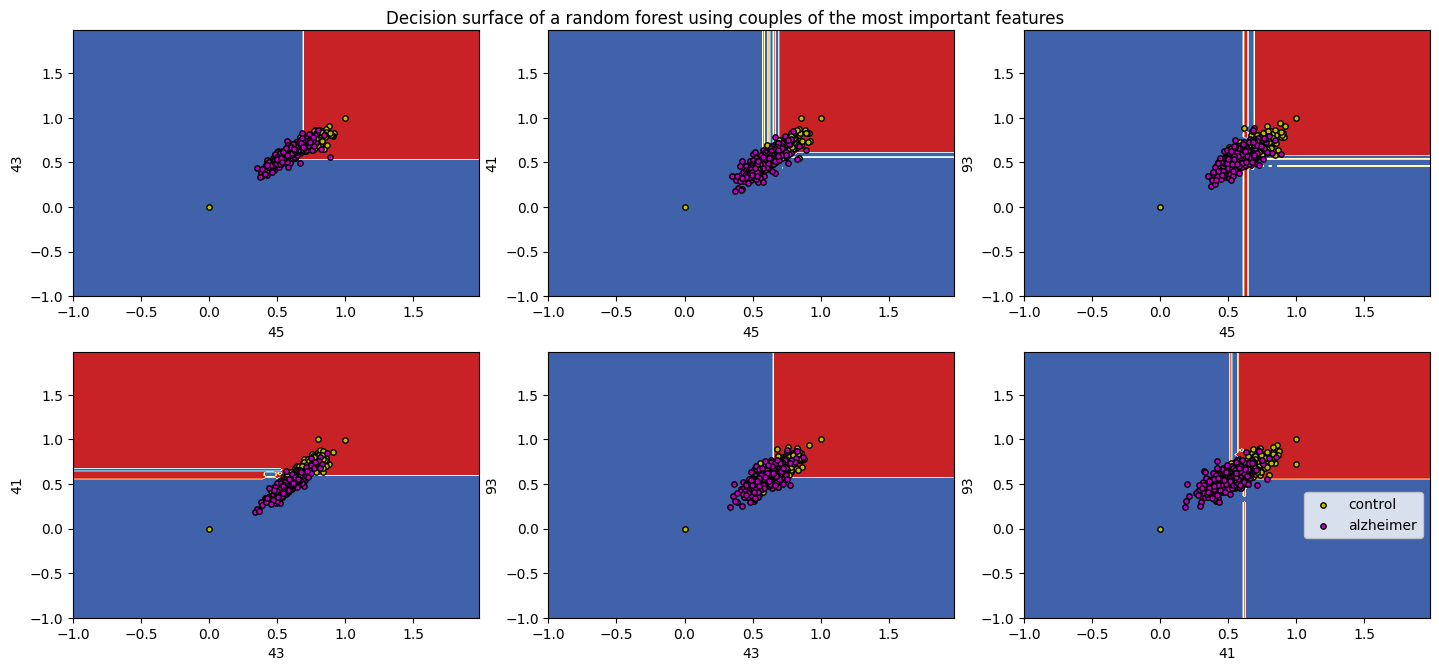

In [21]:
plt.figure(figsize=(15,7))
for pairidx, pair in enumerate([ [indices[0],indices[1]], [indices[0],indices[2]], [indices[0],indices[3]],
                                [indices[1],indices[2]], [indices[1],indices[3]], [indices[2],indices[3]] ]):
    # We only take the two corresponding features
    Xpair = X_train[:, pair]
    ypair = y_train

    # Train
    clf = RF.fit(Xpair, ypair)

    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    x_min, x_max = Xpair[:, 0].min() - 1, Xpair[:, 0].max() + 1
    y_min, y_max = Xpair[:, 1].min() - 1, Xpair[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel(pair[0])
    plt.ylabel(pair[1])

    # Plot the training points
    for i, color in zip(range(2), "ym"):
        idx = np.where(ypair == i)
        plt.scatter(Xpair[idx, 0], Xpair[idx, 1], c=color, label=class_names[i],
                    cmap=plt.cm.RdYlBu, edgecolor='black', s=15)

plt.suptitle("Decision surface of a random forest using couples of the most important features")
plt.legend(bbox_to_anchor=(1, 0.5))
plt.axis("tight")
plt.show()

**Question**: Which is the best couple of features ?

The decision surface visualizes where the model's decision boundary lies in the space defined by two features. Each plot corresponds to a pair of features, and the data points are colored based on the actual class labels (control or Alzheimer's).

To determine the best pair of features, we would look for the decision surface that shows the most distinct separation between the control and Alzheimer's classes, which would be indicative of better classification performance. The ideal decision surface would have:

- A clear boundary between the red and blue areas, indicating a decisive split made by the classifier.
- Minimal overlap of yellow and purple points on opposite sides of the boundary, as this would indicate misclassified instances.

From a visual inspection of the image , the best couple of features would be the pair that creates a decision boundary with the least amount of class overlap and the most accurate classification of data points: (43, 45) and (93, 43).

**Different Atlas**

Previously, we have used the AAL2 which defines a precise split of the brain into ROIs. What happens if you change Atlas ? Do you obtain the same results ? Can you find a subset of ROIs that you could define 'biomarkers' of the Alzheimer's disease ? Justify your answer and check whether it makes sense by using the two given research papers.

You can use the AICHA (http://www.gin.cnrs.fr/fr/outils/aicha/) and HAMMERS (https://brain-development.org/brain-atlases/adult-brain-atlases/) atlas.

Number of controls and Alzheimer patients is respectively: 416.0 and 336.0
Number of ROI (features) is: 192


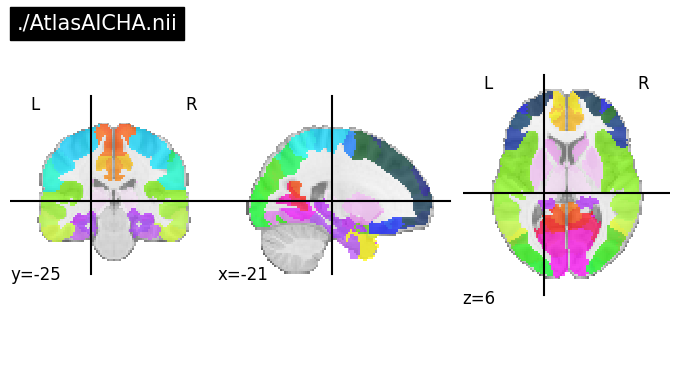

In [22]:
# Changing the Atlas to AICHA and doing the same analysis

X = T1AICHA # T1AAL2, T1AICHA, T1HAMMERS
labels = ROIlabelsAICHA # ROIlabelsAAL2, ROIlabelsAICHA, ROIlabelsHAMMERS
atlas = './AtlasAICHA.nii' #AtlasAAL2.nii, AtlasAICHA.nii, AtlasHAMMERS.nii

N, M = X.shape # number subjects and ROIs
class_names = ["control","alzheimer"] # y=0, y=1

print('Number of controls and Alzheimer patients is respectively: {0} and {1}'.format(N-np.sum(y), np.sum(y)))
print('Number of ROI (features) is: {0}'.format(M))

plotting.plot_roi(atlas, title=atlas)
plotting.show()

In [23]:
# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [24]:
# Fitting Decision Trees
Tree = DecisionTreeClassifier(random_state=0)
Tree.fit(X_train,y_train)

# Score in the training set
print('Score in the training set is {0}'.format(Tree.score(X_train,y_train)) )

# Score in the test set
print('Score in the test set is {0}'.format(Tree.score(X_test,y_test)) )

Score in the training set is 1.0
Score in the test set is 0.6504424778761062


In [25]:
Tree = DecisionTreeClassifier(min_samples_split = 2, min_samples_leaf = 10, random_state = 0)
p_grid_tree = {'min_samples_split': range(2,16), 'min_samples_leaf': range(1,16)}
grid_tree = GridSearchCV(estimator=Tree, param_grid = p_grid_tree, cv=5)
grid_tree.fit(X_train, y_train)
print("Best Validation Score: {}".format(grid_tree.best_score_))
print("Best params: {}".format(grid_tree.best_params_))
print("Tree test score :",grid_tree.score(X_test, y_test))

best_params = grid_tree.best_params_

Best Validation Score: 0.7261275831087153
Best params: {'min_samples_leaf': 1, 'min_samples_split': 3}
Tree test score : 0.6460176991150443


In [26]:
RF = RandomForestClassifier(random_state = 0)
p_grid_RF = {'n_estimators': [10, 15, 20, 25, 30], 'min_samples_leaf': [2, 3, 4, 5, 6], 'max_features': ['sqrt', 'log2']}
grid_RF = GridSearchCV(estimator = RF, param_grid = p_grid_RF, scoring = 'accuracy', cv = 5)
grid_RF.fit(X_train, y_train)

print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("Random Forest test score :", grid_RF.score(X_test, y_test))

C:\Users\lmcastanedame\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\lmcastanedame\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\lmcastanedame\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pleas

Best Validation Score: 0.7833243486073675
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 30}
Random Forest test score : 0.7079646017699115


C:\Users\lmcastanedame\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


C:\Users\lmcastanedame\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Feature ranking:
1. feature 187 representing 188	N_Thalamus-5	189
 (0.046401)
2. feature 144 representing 145	S_Parietooccipital-4	146
 (0.042894)
3. feature 188 representing 189	N_Thalamus-6	190
 (0.037021)
4. feature 172 representing 173	N_Amygdala-1	174
 (0.028438)
5. feature 173 representing 174	N_Caudate-1	175
 (0.023360)
6. feature 189 representing 190	N_Thalamus-7	191
 (0.020344)
7. feature 170 representing 171	G_Fusiform-6	172
 (0.019595)
8. feature 74 representing 75	G_Insula-anterior-3	76
 (0.019297)
9. feature 180 representing 181	N_Pallidum-1	182
 (0.016066)
10. feature 171 representing 172	G_Fusiform-7	173
 (0.016023)


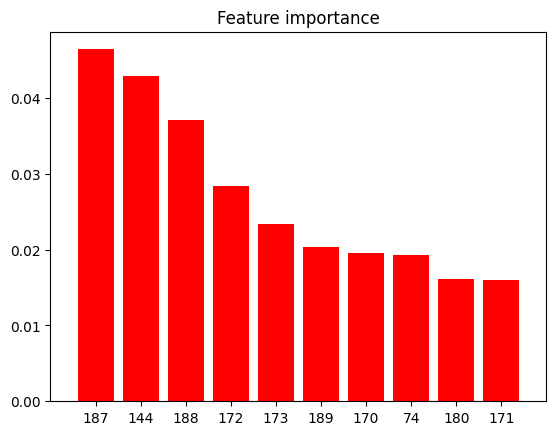

In [27]:
best_params = grid_RF.best_params_
RF = RandomForestClassifier(min_samples_leaf = best_params["min_samples_leaf"], max_features = best_params["max_features"],
                            n_estimators = best_params["n_estimators"], random_state = 0)
RF.fit(X_train,y_train)

importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(10):
    print("%d. feature %d representing %s (%f)" % (f + 1, indices[f], labels[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance")
plt.bar(range(10), importances[indices[0:10]], color="r", align="center")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()

C:\Users\lmcastanedame\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\lmcastanedame\AppData\Local\Temp\ipykernel_14576\349578214.py:30: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(Xpair[idx, 0], Xpair[idx, 1], c=color, label=class_names[i],
C:\Users\lmcastanedame\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\lmcasta

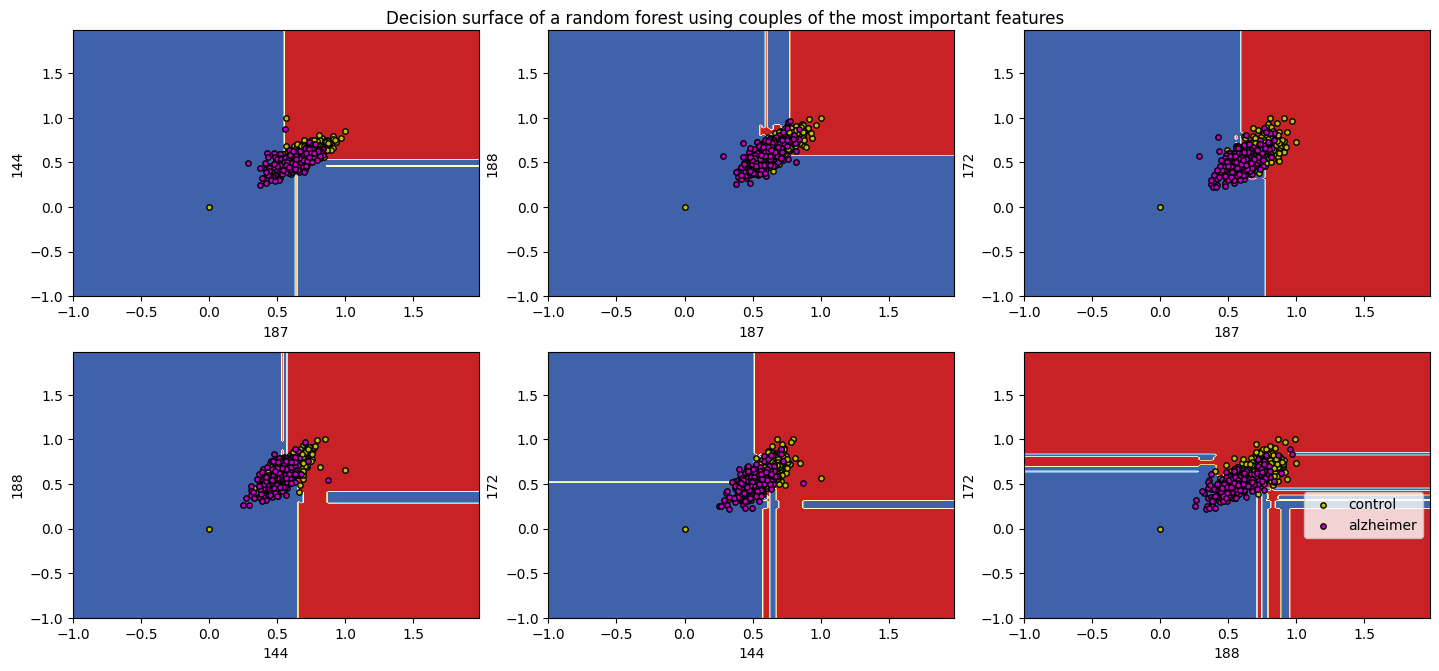

In [28]:
plt.figure(figsize=(15,7))
for pairidx, pair in enumerate([ [indices[0],indices[1]], [indices[0],indices[2]], [indices[0],indices[3]],
                                [indices[1],indices[2]], [indices[1],indices[3]], [indices[2],indices[3]] ]):
    # We only take the two corresponding features
    Xpair = X_train[:, pair]
    ypair = y_train

    # Train
    clf = RF.fit(Xpair, ypair)

    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    x_min, x_max = Xpair[:, 0].min() - 1, Xpair[:, 0].max() + 1
    y_min, y_max = Xpair[:, 1].min() - 1, Xpair[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel(pair[0])
    plt.ylabel(pair[1])

    # Plot the training points
    for i, color in zip(range(2), "ym"):
        idx = np.where(ypair == i)
        plt.scatter(Xpair[idx, 0], Xpair[idx, 1], c=color, label=class_names[i],
                    cmap=plt.cm.RdYlBu, edgecolor='black', s=15)
        
plt.suptitle("Decision surface of a random forest using couples of the most important features")
plt.legend(bbox_to_anchor=(1, 0.5))
plt.axis("tight")
plt.show()

Number of controls and Alzheimer patients is respectively: 416.0 and 336.0
Number of ROI (features) is: 68


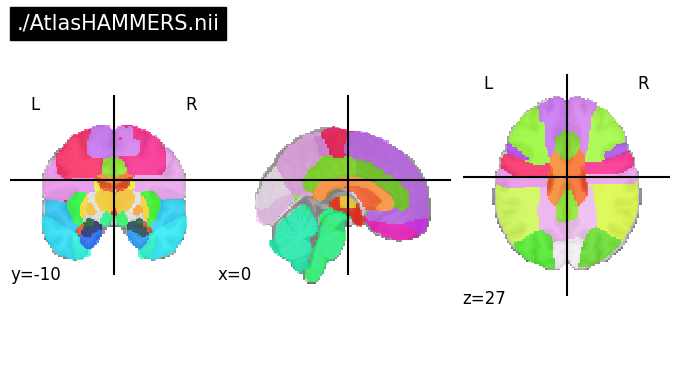

In [29]:
# Changing the Atlas to HAMMERS and doing the same analysis

X = T1HAMMERS # T1AAL2, T1AICHA, T1HAMMERS
labels = ROIlabelsHAMMERS # ROIlabelsAAL2, ROIlabelsAICHA, ROIlabelsHAMMERS
atlas = './AtlasHAMMERS.nii' #AtlasAAL2.nii, AtlasAICHA.nii, AtlasHAMMERS.nii

N, M = X.shape # number subjects and ROIs
class_names = ["control","alzheimer"] # y=0, y=1

print('Number of controls and Alzheimer patients is respectively: {0} and {1}'.format(N-np.sum(y), np.sum(y)))
print('Number of ROI (features) is: {0}'.format(M))

plotting.plot_roi(atlas, title=atlas)
plotting.show()

In [30]:
# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [31]:
# Fitting Decision Trees
Tree = DecisionTreeClassifier(random_state=0)
Tree.fit(X_train,y_train)

# Score in the training set
print('Score in the training set is {0}'.format(Tree.score(X_train,y_train)) )

# Score in the test set
print('Score in the test set is {0}'.format(Tree.score(X_test,y_test)) )

Score in the training set is 1.0
Score in the test set is 0.7168141592920354


In [32]:
Tree = DecisionTreeClassifier(min_samples_split = 2, min_samples_leaf = 10, random_state = 0)
p_grid_tree = {'min_samples_split': range(2,16), 'min_samples_leaf': range(1,16)}
grid_tree = GridSearchCV(estimator=Tree, param_grid = p_grid_tree, cv=5)
grid_tree.fit(X_train, y_train)
print("Best Validation Score: {}".format(grid_tree.best_score_))
print("Best params: {}".format(grid_tree.best_params_))
print("Tree test score :",grid_tree.score(X_test, y_test))

best_params = grid_tree.best_params_

Best Validation Score: 0.775633423180593
Best params: {'min_samples_leaf': 15, 'min_samples_split': 2}
Tree test score : 0.7610619469026548


In [33]:
RF = RandomForestClassifier(random_state = 0)
p_grid_RF = {'n_estimators': [10, 15, 20, 25, 30], 'min_samples_leaf': [2, 3, 4, 5, 6], 'max_features': ['sqrt', 'log2']}
grid_RF = GridSearchCV(estimator = RF, param_grid = p_grid_RF, scoring = 'accuracy', cv = 5)
grid_RF.fit(X_train, y_train)

print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("Random Forest test score :", grid_RF.score(X_test, y_test))

C:\Users\lmcastanedame\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\lmcastanedame\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\lmcastanedame\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pleas

Best Validation Score: 0.8403234501347709
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 30}
Random Forest test score : 0.8141592920353983


C:\Users\lmcastanedame\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


C:\Users\lmcastanedame\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Feature ranking:
1. feature 3 representing Right Amygdala                         (0.112696)
2. feature 0 representing Left Hippocampus                       (0.062594)
3. feature 2 representing Left Amygdala                          (0.062337)
4. feature 12 representing Left Inferior Middle Temporal Gyri     (0.047017)
5. feature 1 representing Right Hippocampus                      (0.046947)
6. feature 46 representing Left Lateral Temporal Ventricle        (0.042617)
7. feature 13 representing Right Inferior Middle Temporal Gyri    (0.027293)
8. feature 47 representing Right Lateral Temporal Ventricle       (0.024905)
9. feature 8 representing Left Ambient and Parahippocampus Gyri  (0.024582)
10. feature 5 representing Right Anterior Medial Temporal Lobe    (0.023752)


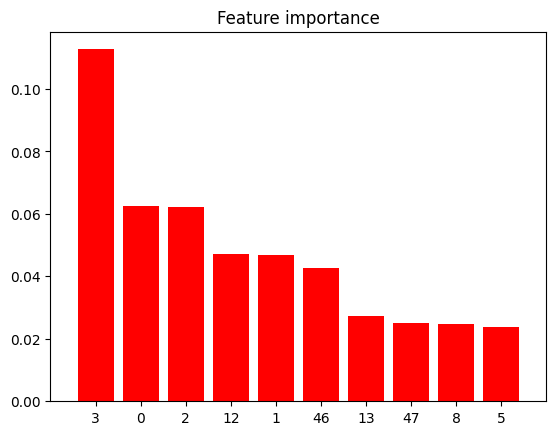

In [34]:
best_params = grid_RF.best_params_
RF = RandomForestClassifier(min_samples_leaf = best_params["min_samples_leaf"], max_features = best_params["max_features"],
                            n_estimators = best_params["n_estimators"], random_state = 0)
RF.fit(X_train,y_train)

importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(10):
    print("%d. feature %d representing %s (%f)" % (f + 1, indices[f], labels[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance")
plt.bar(range(10), importances[indices[0:10]], color="r", align="center")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()

C:\Users\lmcastanedame\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\lmcastanedame\AppData\Local\Temp\ipykernel_14576\349578214.py:30: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(Xpair[idx, 0], Xpair[idx, 1], c=color, label=class_names[i],
C:\Users\lmcastanedame\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\lmcasta

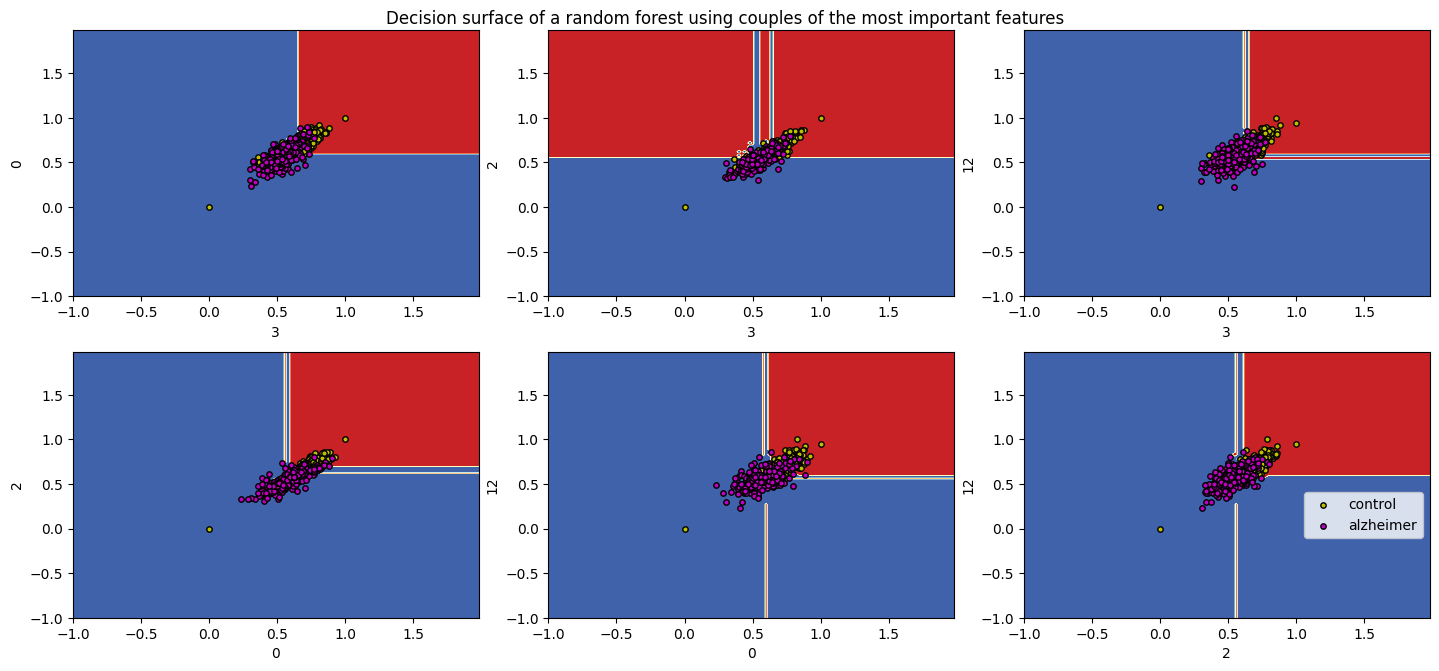

In [35]:
plt.figure(figsize=(15,7))
for pairidx, pair in enumerate([ [indices[0],indices[1]], [indices[0],indices[2]], [indices[0],indices[3]],
                                [indices[1],indices[2]], [indices[1],indices[3]], [indices[2],indices[3]] ]):
    # We only take the two corresponding features
    Xpair = X_train[:, pair]
    ypair = y_train

    # Train
    clf = RF.fit(Xpair, ypair)

    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    x_min, x_max = Xpair[:, 0].min() - 1, Xpair[:, 0].max() + 1
    y_min, y_max = Xpair[:, 1].min() - 1, Xpair[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel(pair[0])
    plt.ylabel(pair[1])

    # Plot the training points
    for i, color in zip(range(2), "ym"):
        idx = np.where(ypair == i)
        plt.scatter(Xpair[idx, 0], Xpair[idx, 1], c=color, label=class_names[i],
                    cmap=plt.cm.RdYlBu, edgecolor='black', s=15)
        
plt.suptitle("Decision surface of a random forest using couples of the most important features")
plt.legend(bbox_to_anchor=(1, 0.5))
plt.axis("tight")
plt.show()

When changed the atlas used to define brain regions of interest (ROIs), it's quite common to see some variation in which features are ranked as most important. This is because each atlas may define regions differently, both in terms of spatial location and the brain functions they're thought to represent. However, even with different atlases, there might be some overlap in the regions identified as important, which can help in defining potential biomarkers for Alzheimer's disease.

**Commonalities:**
- The **Amygdala** (Right Amygdala in AAL2, N_Amygdala-1 in AICHA, and Right and Left Amygdala in HAMMERS) is consistently identified across all atlases, which suggests its significance in Alzheimer's disease. This is consistent with literature, as the amygdala is known to be involved in the early stages of Alzheimer's disease.
- The **Hippocampus** is another region identified by all three atlases (although with side differences). Given its role in memory and cognition, its association with Alzheimer's disease is well established.

**Differences:**
- The **Thalamus** appears as an important feature in the AICHA atlas but not in AAL2 or HAMMERS. This could be due to the different ways the thalamus is segmented across atlases.
- The **Fusiform gyrus** appears in both AAL2 and AICHA but is not highlighted in the top features of the HAMMERS atlas.
- The AICHA and HAMMERS atlases highlight additional regions that AAL2 does not, such as the **Caudate**, **Parietooccipital** areas, and **Lateral Temporal Ventricle**. 

**Biomarker Identification:**
- The consistent identification of the Amygdala and Hippocampus across all three atlases strengthens their candidacy as biomarkers for Alzheimer's disease.
- Regions such as the **Fusiform gyrus** and **Temporal regions** appear in multiple atlases as well, which supports their potential role as biomarkers, though their candidacy is not as strong as the Amygdala and Hippocampus.

Biomarkers for Alzheimer's disease should ideally be consistent across different datasets and analytical approaches. The fact that certain regions are repeatedly identified across different atlases despite the methodological differences adds to their validity. However, some regions might be highlighted or obscured based on how an atlas defines its ROIs. When an ROI comprises both affected and unaffected tissues, or if it splits an affected region into multiple parts, this can either dilute or concentrate the importance score, respectively.